In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
from spacy import displacy
from spacy import tokenizer
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import gensim
import gensim.corpora as corpora
from gensim.models.coherencemodel import CoherenceModel
from gensim.models import LsiModel, TfidfModel
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import accuracy_score, classification_report

In [2]:
data = pd.read_csv("fake_news_data.csv")
data.head()

,title,text,date,fake_or_factual
0,HOLLYWEIRD LIB SUSAN SARANDON Compares Muslim ...,There are two small problems with your analogy...,"Dec 30, 2015",Fake News
1,Elijah Cummings Called Trump Out To His Face ...,Buried in Trump s bonkers interview with New Y...,"April 6, 2017",Fake News
2,Hillary Clinton Says Half Her Cabinet Will Be...,"Women make up over 50 percent of this country,...","April 26, 2016",Fake News
3,Russian bombing of U.S.-backed forces being di...,WASHINGTON (Reuters) - U.S. Defense Secretary ...,"September 18, 2017",Factual News
4,Britain says window to restore Northern Irelan...,BELFAST (Reuters) - Northern Ireland s politic...,"September 4, 2017",Factual News


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 198 entries, 0 to 197
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   title            198 non-null    object
 1   text             198 non-null    object
 2   date             198 non-null    object
 3   fake_or_factual  198 non-null    object
dtypes: object(4)
memory usage: 6.3+ KB


Text(0.5, 1.0, 'Count of Article Classification')

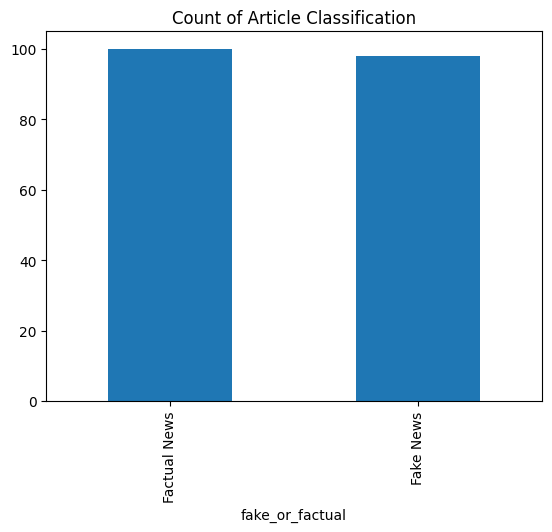

In [4]:
data["fake_or_factual"].value_counts().plot(kind = "bar")
plt.title("Count of Article Classification")

## POS Tagging

In [5]:
nlp = spacy.load("en_core_web_sm")

In [6]:
fake_news = data[data["fake_or_factual"] == "Fake News"]
fact_news = data[data["fake_or_factual"] == "Factual News"]

In [7]:
# fake ve gerçek haber verilerinin textlerini birleştiriyoruz
fake_spacydocs = list(nlp.pipe(fake_news["text"]))
fact_spacydocs = list(nlp.pipe(fact_news["text"]))

In [8]:
# Bu fonksiyon spaCy ile işlenmiş bir metindeki her kelimeyi alır ve
# (kelime, entity türü, kelime türü) şeklinde etiketli bir liste üretir.
def extract_token_tags(doc:spacy.tokens.doc.Doc):
    return [(i.text, i.ent_type_, i.pos_) for i in doc]

In [9]:
fake_tagsDf = []
columns = ["token", "ner_tag", "pos_tag"]

In [10]:
for ix, doc in enumerate(fake_spacydocs):
    tags = extract_token_tags(doc)
    tags = pd.DataFrame(tags)
    tags.columns = columns
    fake_tagsDf.append(tags)

In [11]:
fake_tagsDf = pd.concat(fake_tagsDf)

In [12]:
fake_tagsDf.head()

,token,ner_tag,pos_tag
0,There,,PRON
1,are,,VERB
2,two,CARDINAL,NUM
3,small,,ADJ
4,problems,,NOUN


In [13]:
fact_tagsDf = []
for ix, doc in enumerate(fact_spacydocs):
    tags = extract_token_tags(doc)
    tags = pd.DataFrame(tags)
    tags.columns = columns
    fact_tagsDf.append(tags)

In [14]:
fact_tagsDf = pd.concat(fact_tagsDf)

In [15]:
pos_counts_fake = fake_tagsDf.groupby(["token", "pos_tag"]).size().reset_index(name = "counts").sort_values(by = "counts", ascending=False)

In [16]:
pos_counts_fake.head(10)

,token,pos_tag,counts
29,",",PUNCT,1908
7451,the,DET,1834
41,.,PUNCT,1530
5766,of,ADP,922
2665,and,CCONJ,875
2449,a,DET,805
0,,SPACE,795
7528,to,PART,767
4921,in,ADP,668
5099,is,AUX,419


In [17]:
pos_counts_fact = fact_tagsDf.groupby(["token", "pos_tag"]).size().reset_index(name = "counts").sort_values(by = "counts", ascending=False)
pos_counts_fact.head(10)

,token,pos_tag,counts
6145,the,DET,1903
14,",",PUNCT,1698
21,.,PUNCT,1382
4716,of,ADP,884
1898,a,DET,789
2093,and,CCONJ,757
4005,in,ADP,671
6205,to,PART,660
4743,on,ADP,482
5567,said,VERB,451


In [18]:
pos_counts_fake.groupby("pos_tag")["token"].count().sort_values(ascending=False).head()

pos_tag
NOUN     2586
VERB     1817
PROPN    1672
ADJ       882
ADV       413
Name: token, dtype: int64

In [19]:
pos_counts_fact.groupby("pos_tag")["token"].count().sort_values(ascending=False).head()

pos_tag
NOUN     2179
VERB     1539
PROPN    1379
ADJ       747
ADV       263
Name: token, dtype: int64

In [20]:
pos_counts_fake[pos_counts_fake.pos_tag == "NOUN"][:15]

,token,pos_tag,counts
5981,people,NOUN,77
7349,t,NOUN,65
6216,president,NOUN,58
7960,women,NOUN,55
7516,time,NOUN,52
3138,campaign,NOUN,44
8011,year,NOUN,44
4581,government,NOUN,41
5213,law,NOUN,40
8013,years,NOUN,40


In [21]:
pos_counts_fact[pos_counts_fact.pos_tag == "NOUN"][:15]

,token,pos_tag,counts
3738,government,NOUN,71
6618,year,NOUN,64
5901,state,NOUN,57
2360,bill,NOUN,55
1975,administration,NOUN,51
5066,president,NOUN,49
3277,election,NOUN,48
4919,people,NOUN,45
4786,order,NOUN,45
4259,law,NOUN,42


## Named Entities

In [22]:
fake_tagsDf.head()

,token,ner_tag,pos_tag
0,There,,PRON
1,are,,VERB
2,two,CARDINAL,NUM
3,small,,ADJ
4,problems,,NOUN


In [23]:
 top_entities_fake = fake_tagsDf[fake_tagsDf["ner_tag"]!= ""].groupby(["token", "ner_tag"]).size().reset_index(name="counts").sort_values(by= "counts", ascending=False)
 top_entities_fact = fact_tagsDf[fact_tagsDf["ner_tag"]!= ""].groupby(["token", "ner_tag"]).size().reset_index(name="counts").sort_values(by= "counts", ascending=False)

In [24]:
# create custom palette to ensure plots are consistent
ner_palette = {
    'ORG': sns.color_palette("Set2").as_hex()[0],
    'GPE': sns.color_palette("Set2").as_hex()[1],
    'NORP': sns.color_palette("Set2").as_hex()[2],
    'PERSON': sns.color_palette("Set2").as_hex()[3],
    'DATE': sns.color_palette("Set2").as_hex()[4],
    'CARDINAL': sns.color_palette("Set2").as_hex()[5],
    'PERCENT': sns.color_palette("Set2").as_hex()[6]
}

[Text(0.5, 1.0, 'Most Common Entities in Fake News')]

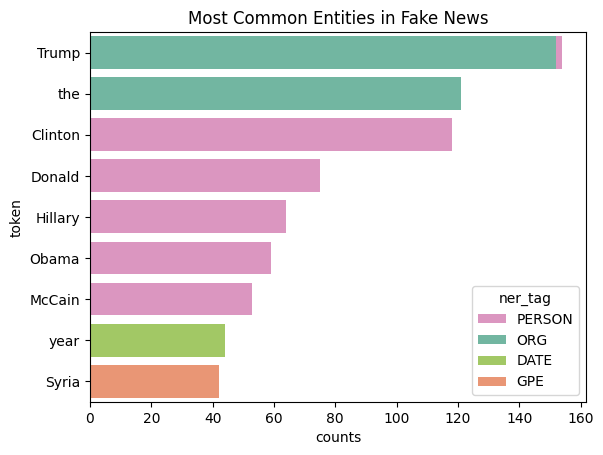

In [25]:
sns.barplot(
    x = 'counts',
    y = 'token',
    hue = 'ner_tag',
    palette = ner_palette,
    data = top_entities_fake[0:10],
    orient = 'h',
    dodge=False
) \
.set(title='Most Common Entities in Fake News')

[Text(0.5, 1.0, 'Most Common Entities in Fake News')]

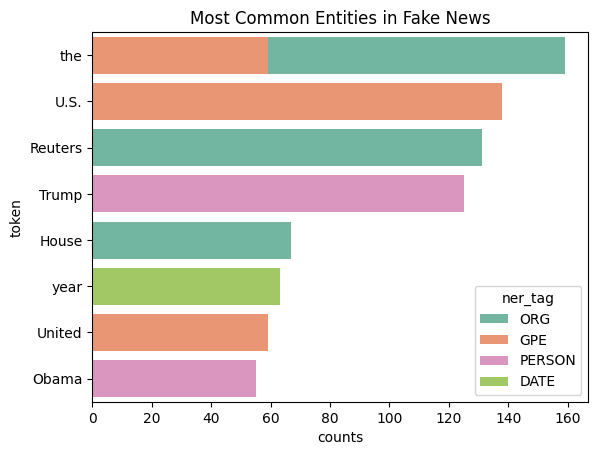

In [26]:
sns.barplot(
    x = 'counts',
    y = 'token',
    hue = 'ner_tag',
    palette = ner_palette,
    data = top_entities_fact[0:10],
    orient = 'h',
    dodge=False
) \
.set(title='Most Common Entities in Fake News')

## Text Pre-processing

In [28]:
# a lot of the factual news has a location tag at the beginning of the article, let's use regex to remove this
data['text_clean'] = data.apply(lambda x: re.sub(r"^[^-]*-\s*", "", x['text']), axis=1)

In [29]:
# lowercase 
data['text_clean'] = data['text_clean'].str.lower()

In [30]:
# remove punctuation
data['text_clean'] = data.apply(lambda x: re.sub(r"([^\w\s])", "", x['text_clean']), axis=1)

In [32]:
# stop words
en_stopwords = stopwords.words('english')
print(en_stopwords)

['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own', 're', 's', 'same', 'shan', "shan't", 'she

In [33]:
data['text_clean'] = data['text_clean'].apply(lambda x: ' '.join([word for word in x.split() if word not in (en_stopwords)]))

In [34]:
# tokenize 
data['text_clean'] = data.apply(lambda x: word_tokenize(x['text_clean']), axis=1)

In [35]:
data["text_clean"].head()

0    [yearold, oscarwinning, actress, described, me...
1    [buried, trump, bonkers, interview, new, york,...
2    [women, make, 50, percent, country, grossly, u...
3    [us, defense, secretary, jim, mattis, said, mo...
4    [northern, ireland, political, parties, rapidl...
Name: text_clean, dtype: object

In [36]:
# lemmatize
lemmatizer = WordNetLemmatizer()
data["text_clean"] = data["text_clean"].apply(lambda tokens: [lemmatizer.lemmatize(token) for token in tokens])

In [37]:
data["text_clean"].head()

0    [yearold, oscarwinning, actress, described, me...
1    [buried, trump, bonkers, interview, new, york,...
2    [woman, make, 50, percent, country, grossly, u...
3    [u, defense, secretary, jim, mattis, said, mon...
4    [northern, ireland, political, party, rapidly,...
Name: text_clean, dtype: object

In [38]:
data.head()

,title,text,date,fake_or_factual,text_clean
0,HOLLYWEIRD LIB SUSAN SARANDON Compares Muslim ...,There are two small problems with your analogy...,"Dec 30, 2015",Fake News,"[yearold, oscarwinning, actress, described, me..."
1,Elijah Cummings Called Trump Out To His Face ...,Buried in Trump s bonkers interview with New Y...,"April 6, 2017",Fake News,"[buried, trump, bonkers, interview, new, york,..."
2,Hillary Clinton Says Half Her Cabinet Will Be...,"Women make up over 50 percent of this country,...","April 26, 2016",Fake News,"[woman, make, 50, percent, country, grossly, u..."
3,Russian bombing of U.S.-backed forces being di...,WASHINGTON (Reuters) - U.S. Defense Secretary ...,"September 18, 2017",Factual News,"[u, defense, secretary, jim, mattis, said, mon..."
4,Britain says window to restore Northern Irelan...,BELFAST (Reuters) - Northern Ireland s politic...,"September 4, 2017",Factual News,"[northern, ireland, political, party, rapidly,..."


In [39]:
# most common unigrams after preprocessing
tokens_clean = sum(data['text_clean'], [])
unigrams = (pd.Series(nltk.ngrams(tokens_clean, 1)).value_counts()).reset_index()[:10]
print(unigrams)

           index  count
0        (said,)    560
1       (trump,)    520
2           (u,)    255
3       (state,)    250
4   (president,)    226
5       (would,)    210
6         (one,)    141
7        (year,)    128
8  (republican,)    128
9        (also,)    124


[Text(0.5, 1.0, 'Most Common Unigrams After Preprocessing')]

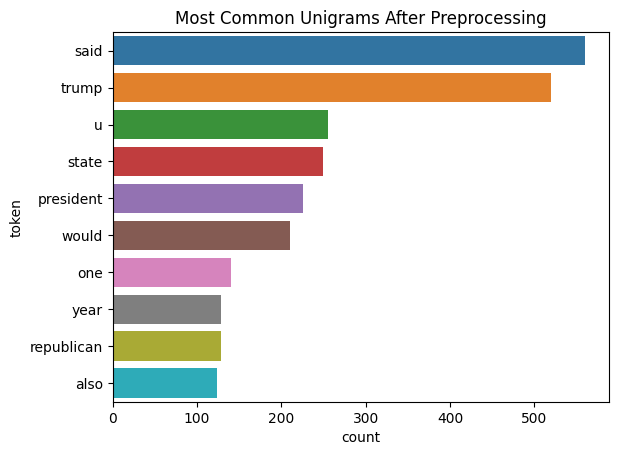

In [41]:
unigrams['token'] = unigrams['index'].apply(lambda x: x[0]) # extract the token from the tuple so we can plot it

sns.barplot(x = "count", 
            y = "token", 
            data=unigrams,
            orient = 'h',
            palette="tab10",
            hue = "token", legend = False)\
.set(title='Most Common Unigrams After Preprocessing')

In [42]:
# most common bigrams after preprocessing
bigrams = (pd.Series(nltk.ngrams(tokens_clean, 2)).value_counts()) 
print(bigrams[:10])

(donald, trump)        92
(united, state)        80
(white, house)         72
(president, donald)    42
(hillary, clinton)     31
(new, york)            31
(image, via)           29
(supreme, court)       29
(official, said)       26
(food, stamp)          24
Name: count, dtype: int64


## Sentiment Analysis

In [44]:
vader_sentiment = SentimentIntensityAnalyzer()

In [45]:
data["vader_sentiment_score"] = data["text"].apply(lambda review: vader_sentiment.polarity_scores(review)["compound"])

In [46]:
data["vader_sentiment_score"].head()

0   -0.3660
1   -0.8197
2    0.9779
3   -0.3400
4    0.8590
Name: vader_sentiment_score, dtype: float64

In [47]:
# create labels
bins = [-1, -0.1, 0.1, 1]
names = ['negative', 'neutral', 'positive']

data['vader_sentiment_label'] = pd.cut(data['vader_sentiment_score'], bins, labels=names)

<Axes: xlabel='vader_sentiment_label'>

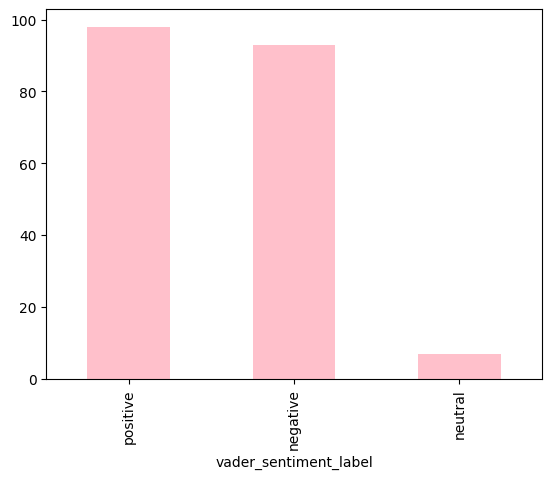

In [48]:
data['vader_sentiment_label'].value_counts().plot.bar(color="pink")

C:\Users\berka\AppData\Local\Temp\ipykernel_23520\3014756626.py:1: UserWarning: The palette list has more values (6) than needed (3), which may not be intended.
  sns.countplot(


[Text(0.5, 1.0, 'Sentiment by News Type')]

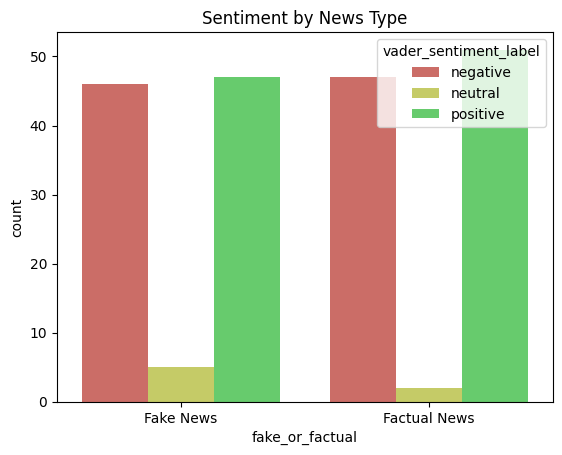

In [49]:
sns.countplot(
    x = 'fake_or_factual',
    hue = 'vader_sentiment_label',
    palette = sns.color_palette("hls"),
    data = data
) \
.set(title='Sentiment by News Type')

## LDA

In [50]:
# fake news data vectorization
fake_news_text = data[data['fake_or_factual'] == "Fake News"]['text_clean'].reset_index(drop=True)
dictionary_fake = corpora.Dictionary(fake_news_text)
doc_term_fake = [dictionary_fake.doc2bow(text) for text in fake_news_text]

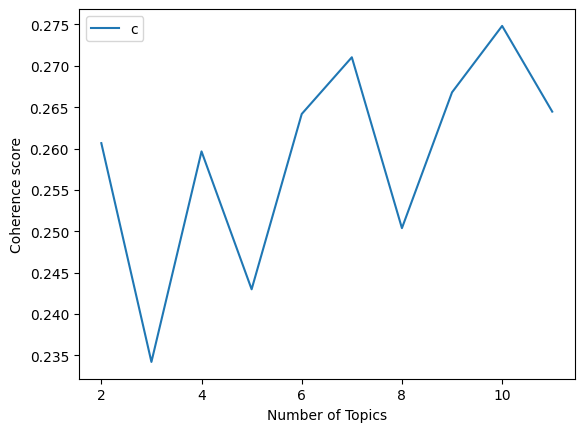

In [51]:
# generate coherence scores to determine an optimum number of topics
coherence_values = []
model_list = []

min_topics = 2
max_topics = 11

for num_topics_i in range(min_topics, max_topics+1):
    model = gensim.models.LdaModel(doc_term_fake, num_topics=num_topics_i, id2word = dictionary_fake)
    model_list.append(model)
    coherence_model = CoherenceModel(model=model, texts=fake_news_text, dictionary=dictionary_fake, coherence='c_v')
    coherence_values.append(coherence_model.get_coherence())
    
plt.plot(range(min_topics, max_topics+1), coherence_values)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [52]:
# create lda model
num_topics_fake = 6 

lda_model_fake = gensim.models.LdaModel(corpus=doc_term_fake,
                                       id2word=dictionary_fake,
                                       num_topics=num_topics_fake)

lda_model_fake.print_topics(num_topics=num_topics_fake, num_words=10)

[(0,
  '0.013*"trump" + 0.006*"president" + 0.004*"republican" + 0.004*"said" + 0.004*"clinton" + 0.004*"state" + 0.004*"year" + 0.004*"time" + 0.003*"one" + 0.003*"would"'),
 (1,
  '0.007*"trump" + 0.006*"clinton" + 0.006*"said" + 0.005*"state" + 0.003*"president" + 0.003*"republican" + 0.003*"u" + 0.003*"time" + 0.003*"one" + 0.003*"american"'),
 (2,
  '0.015*"trump" + 0.005*"would" + 0.004*"said" + 0.003*"one" + 0.003*"president" + 0.003*"time" + 0.003*"also" + 0.003*"republican" + 0.003*"supporter" + 0.003*"woman"'),
 (3,
  '0.006*"trump" + 0.005*"said" + 0.004*"president" + 0.004*"mccain" + 0.004*"u" + 0.003*"clinton" + 0.003*"state" + 0.003*"time" + 0.003*"syria" + 0.003*"people"'),
 (4,
  '0.008*"trump" + 0.004*"would" + 0.004*"clinton" + 0.004*"said" + 0.004*"state" + 0.004*"time" + 0.004*"u" + 0.003*"woman" + 0.003*"one" + 0.003*"president"'),
 (5,
  '0.014*"trump" + 0.005*"said" + 0.004*"one" + 0.004*"state" + 0.004*"clinton" + 0.003*"people" + 0.003*"image" + 0.003*"woman" +

In [53]:
# our topics contain a lot of very similar words, let's try using latent semantic anaysis with tf-idf vectorization

## TF-IDF & LSA

In [54]:
def tfidf_corpus(doc_term_matrix):
    # create a corpus using tfidf vecotization
    tfidf = TfidfModel(corpus=doc_term_matrix, normalize=True)
    corpus_tfidf = tfidf[doc_term_matrix]
    return corpus_tfidf

In [55]:
def get_coherence_scores(corpus, dictionary, text, min_topics, max_topics):
    # generate coherence scores to determine an optimum number of topics
    coherence_values = []
    model_list = []
    for num_topics_i in range(min_topics, max_topics+1):
        model = LsiModel(corpus, num_topics=num_topics_i, id2word = dictionary, random_seed=0)
        model_list.append(model)
        coherence_model = CoherenceModel(model=model, texts=text, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherence_model.get_coherence())
    # plot results
    plt.plot(range(min_topics, max_topics+1), coherence_values)
    plt.xlabel("Number of Topics")
    plt.ylabel("Coherence score")
    plt.legend(("coherence_values"), loc='best')
    plt.show()

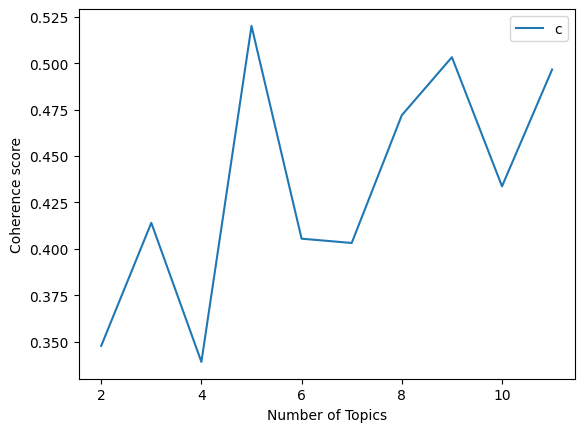

In [56]:
# create tfidf representation
corpus_tfidf_fake = tfidf_corpus(doc_term_fake)
# coherence scores for fake news data
get_coherence_scores(corpus_tfidf_fake, dictionary_fake, fake_news_text, min_topics=2, max_topics=11)

In [57]:
# model for fake news data
lsa_fake = LsiModel(corpus_tfidf_fake, id2word=dictionary_fake, num_topics=5)
lsa_fake.print_topics()

[(0,
  '0.218*"trump" + 0.135*"clinton" + 0.094*"woman" + 0.087*"president" + 0.086*"republican" + 0.085*"obama" + 0.084*"party" + 0.083*"school" + 0.081*"said" + 0.079*"time"'),
 (1,
  '-0.299*"boiler" + -0.253*"room" + -0.250*"acr" + -0.186*"jay" + -0.185*"animal" + -0.176*"episode" + -0.147*"analysis" + -0.122*"dyer" + -0.119*"mediamaniacs" + -0.119*"misguided"'),
 (2,
  '-0.219*"school" + 0.195*"clinton" + 0.163*"conference" + -0.151*"county" + -0.137*"student" + 0.120*"press" + 0.116*"trump" + 0.112*"hillary" + -0.101*"love" + 0.095*"email"'),
 (3,
  '0.375*"flynn" + 0.151*"russian" + 0.111*"email" + 0.109*"30" + 0.101*"department" + 0.100*"information" + 0.100*"nana" + 0.099*"official" + 0.098*"mccain" + -0.096*"trump"'),
 (4,
  '-0.235*"trump" + -0.223*"flynn" + -0.166*"conference" + 0.165*"clinton" + 0.153*"dnc" + 0.151*"sander" + 0.127*"email" + -0.111*"press" + 0.109*"rich" + -0.084*"tax"')]

## Predict fake or factual news

In [58]:
data.head()

,title,text,date,fake_or_factual,text_clean,vader_sentiment_score,vader_sentiment_label
0,HOLLYWEIRD LIB SUSAN SARANDON Compares Muslim ...,There are two small problems with your analogy...,"Dec 30, 2015",Fake News,"[yearold, oscarwinning, actress, described, me...",-0.3660,negative
1,Elijah Cummings Called Trump Out To His Face ...,Buried in Trump s bonkers interview with New Y...,"April 6, 2017",Fake News,"[buried, trump, bonkers, interview, new, york,...",-0.8197,negative
2,Hillary Clinton Says Half Her Cabinet Will Be...,"Women make up over 50 percent of this country,...","April 26, 2016",Fake News,"[woman, make, 50, percent, country, grossly, u...",0.9779,positive
3,Russian bombing of U.S.-backed forces being di...,WASHINGTON (Reuters) - U.S. Defense Secretary ...,"September 18, 2017",Factual News,"[u, defense, secretary, jim, mattis, said, mon...",-0.3400,negative
4,Britain says window to restore Northern Irelan...,BELFAST (Reuters) - Northern Ireland s politic...,"September 4, 2017",Factual News,"[northern, ireland, political, party, rapidly,...",0.8590,positive


In [59]:
X = [','.join(map(str, l)) for l in data['text_clean']]
Y = data['fake_or_factual']

In [61]:

# text vectorization - CountVectorizer
countvec = CountVectorizer()
countvec_fit = countvec.fit_transform(X)
bag_of_words = pd.DataFrame(countvec_fit.toarray(), columns = countvec.get_feature_names_out())

In [62]:
# split into train and test data
X_train, X_test, y_train, y_test = train_test_split(bag_of_words, Y, test_size=0.3)

In [63]:
lr = LogisticRegression(random_state=0).fit(X_train, y_train)

In [64]:
y_pred_lr = lr.predict(X_test)

In [65]:
accuracy_score(y_pred_lr, y_test)

0.8833333333333333

In [66]:
print(classification_report(y_test, y_pred_lr))

              precision    recall  f1-score   support

Factual News       0.87      0.90      0.88        29
   Fake News       0.90      0.87      0.89        31

    accuracy                           0.88        60
   macro avg       0.88      0.88      0.88        60
weighted avg       0.88      0.88      0.88        60



In [67]:
svm = SGDClassifier().fit(X_train, y_train)

In [68]:
y_pred_svm = svm.predict(X_test)

In [69]:
accuracy_score(y_pred_svm, y_test)

0.9166666666666666

In [70]:
print(classification_report(y_test, y_pred_svm))

              precision    recall  f1-score   support

Factual News       0.93      0.90      0.91        29
   Fake News       0.91      0.94      0.92        31

    accuracy                           0.92        60
   macro avg       0.92      0.92      0.92        60
weighted avg       0.92      0.92      0.92        60

